In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import os
os.chdir("../")

In [4]:
import copy

In [5]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
## building vocab of chars & mapping to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
## Building the data set

block_size = 3 ## context length: How many chars to take to predict the next one?

X, Y = [], []

for w in words:
    context = [0] * block_size # -> 1st Iter [0, 0, 0]
    
    for ch in w + ".":

        ix = stoi[ch] ## Encoded values of character
        
        X.append(context) ## 1st Iter [0, 0, 0]
        Y.append(ix) ## 1st Iter [itos[ch]]

        context = context[1:] + [ix] ## Rolling Operation

X = torch.tensor(X)
Y = torch.tensor(Y)

#### Understanding Generated X Shape & Y Shape

1. X shape is (N, Context Size). Where N is number of input samples generated while creating X, Y Pairs and Context Size is defined above

2. Y Shape is (N). For each Input Sample, it contains the next character Output

In [10]:
X.shape, X.dtype, 

(torch.Size([228146, 3]), torch.int64)

In [11]:
Y.shape, Y.dtype

(torch.Size([228146]), torch.int64)

## Projecting characters into 2 Dimensional Space (Embedding Look Up Table)

Number of Chars: 27

Dimensions: 2

In [12]:
C = torch.randn((27, 2))

### Accessing entries of Look-Up Matrix C

In [13]:
## For 5 encoded char "e"
## itos[5]
C[5]

tensor([-1.7176,  1.5213])

In [14]:
## For 0 encoded char "a"
## itos[5]
C[0]

tensor([-0.9423, -0.5978])

In [15]:
## Is there a better way to index Look Up Matrix?
## Yes One Hot Encoding
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.7176,  1.5213])

In [16]:
## First Layer of Neural Language Model is essentially, look up into Embedding matrices for Provide Input

### Getting values for 5th Row & 0th Row simultaneously
C[[5, 0]]

tensor([[-1.7176,  1.5213],
        [-0.9423, -0.5978]])

In [17]:
### Getting values for 5th Row , 6th Row & 7th Row ,7th Row, 7th Row simultaneously

C[torch.tensor([5, 6, 7, 7, 7])]

tensor([[-1.7176,  1.5213],
        [-1.2051, -0.4673],
        [-2.7873,  0.3717],
        [-2.7873,  0.3717],
        [-2.7873,  0.3717]])

In [18]:
X.shape, X.dtype, 

(torch.Size([228146, 3]), torch.int64)

### How can I get Embedding Look Up entries for X Input `[N, Context Size]`

In [19]:
## Slicing X Tensor for Single word emma (1st name in data)
X_single_name = X[0:4, :]

In [20]:
X_single_name

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])

In [21]:
## In each row of X
## Number of encoded chars == context sizr
## For each encodeed chars -> (, 2) shape Look-Up Embedding Table output

## End Shape would look like
## (N, Context_Size, Embedding Dim)
C[X_single_name], C[X_single_name].shape

(tensor([[[-0.9423, -0.5978],
          [-0.9423, -0.5978],
          [-0.9423, -0.5978]],
 
         [[-0.9423, -0.5978],
          [-0.9423, -0.5978],
          [-1.7176,  1.5213]],
 
         [[-0.9423, -0.5978],
          [-1.7176,  1.5213],
          [ 0.0677,  0.5995]],
 
         [[-1.7176,  1.5213],
          [ 0.0677,  0.5995],
          [ 0.0677,  0.5995]]]),
 torch.Size([4, 3, 2]))

In [22]:
X[13, 2]

tensor(1)

In [23]:
C[X][13,2]

tensor([ 1.1757, -1.0737])

In [24]:
C[1]

tensor([ 1.1757, -1.0737])

In [25]:
## We can embedd directly by passing X into C and it should work!

emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [26]:
### Constructing Hidden Layer

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [27]:
### Embedding which is input to Hidden Layer has shape of [N, context, embedding dimension] -> (32, 3, 2)
### While Hidden layer neuron shape is (context * embedding dimension, hidden_dim) -> (6, 100)

### Last 2 dimensions of embedding layer needs to combined together so that shape matches for matmul

### One way to solve is to use torch cat function

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [28]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [29]:
### More generic way would be use torch unbind and then use torch cat
### Unbinding is done on dimension where context size is defined

torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[-0.9423, -0.5978, -0.9423, -0.5978, -0.9423, -0.5978],
        [-0.9423, -0.5978, -0.9423, -0.5978, -1.7176,  1.5213],
        [-0.9423, -0.5978, -1.7176,  1.5213,  0.0677,  0.5995],
        ...,
        [-0.7677,  0.1751, -0.7677,  0.1751,  0.0348, -0.4586],
        [-0.7677,  0.1751,  0.0348, -0.4586, -0.7677,  0.1751],
        [ 0.0348, -0.4586, -0.7677,  0.1751,  1.1635, -0.7038]])

In [30]:
Input_Embedding_Proj = copy.deepcopy(C[X])

In [31]:
Input_Embedding_Proj.shape

torch.Size([228146, 3, 2])

In [32]:
#### Easier way to do this

a = torch.arange(18)
a 

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [33]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [34]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [35]:
emb.shape

torch.Size([228146, 3, 2])

In [36]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [37]:
h

tensor([[ 0.9998, -0.6236, -0.4472,  ..., -0.6294,  0.1288, -0.7671],
        [-0.3303, -0.3501,  0.2938,  ...,  0.7509, -0.3984, -0.9867],
        [ 0.9999, -0.8641,  0.9861,  ..., -0.9814, -0.7919, -0.6165],
        ...,
        [ 0.9991,  0.2475, -0.3560,  ..., -0.5424,  0.6240, -0.2447],
        [ 0.7965,  0.9591, -0.6489,  ...,  0.0093,  0.7743, -0.8776],
        [ 0.9993, -0.8510,  0.1439,  ...,  0.2065,  0.8061,  0.6672]])

In [38]:
### Output Layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [39]:
logits = h @ W2 + b2

In [40]:
loss = F.cross_entropy(logits, Y)

In [41]:
loss

tensor(17.9254)

#### Training Loop 

In [42]:
X.shape, Y.shape ## DataSet

(torch.Size([228146, 3]), torch.Size([228146]))

In [152]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g, requires_grad=True)

W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)

W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [153]:
sum(p.nelement() for p in parameters)

3481

In [ ]:
## Estimating Optimal Learning Rate

### Why we want to do that?
### so that we we get optimal learning rate, leading to reduction in loss in less amount of time & computation

### How to do that?

#### Compute loss for different learning rates & at different epochs
#### start with low learning rate, then gradually increase it
#### Select LR which gives lower loss



In [155]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [157]:
lri = []

lossi = []

for i in range(1000):

    # Adding MiniBatch Gradient Descent
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward Pass
    emb = C[X[ix]]

    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Y[ix])


    # print(loss.item())

    ## Backward pass 

    for p in parameters:
        p.grad = None

    loss.backward()

    ## Update

    ## Trying to find optimal learning rate
    lr = lrs[i]
    for p in parameters: 
        p.data += -lr * p.grad

    lri.append(lre[i].item())
    lossi.append(loss.item())

# print(loss.item())


In [158]:
lri

[-3.0,
 -2.9969968795776367,
 -2.9939939975738525,
 -2.9909908771514893,
 -2.987987995147705,
 -2.984984874725342,
 -2.9819819927215576,
 -2.9789788722991943,
 -2.97597599029541,
 -2.972972869873047,
 -2.9699699878692627,
 -2.9669668674468994,
 -2.9639639854431152,
 -2.960960865020752,
 -2.9579579830169678,
 -2.9549548625946045,
 -2.9519519805908203,
 -2.948948860168457,
 -2.945945978164673,
 -2.9429428577423096,
 -2.9399399757385254,
 -2.936936855316162,
 -2.933933973312378,
 -2.9309308528900146,
 -2.9279279708862305,
 -2.924924850463867,
 -2.921921968460083,
 -2.9189188480377197,
 -2.9159159660339355,
 -2.9129128456115723,
 -2.909909963607788,
 -2.906906843185425,
 -2.9039039611816406,
 -2.9009008407592773,
 -2.897897958755493,
 -2.89489483833313,
 -2.8918919563293457,
 -2.8888888359069824,
 -2.8858859539031982,
 -2.882882833480835,
 -2.879879951477051,
 -2.8768768310546875,
 -2.8738739490509033,
 -2.87087082862854,
 -2.867867946624756,
 -2.8648648262023926,
 -2.8618619441986084,
 -2

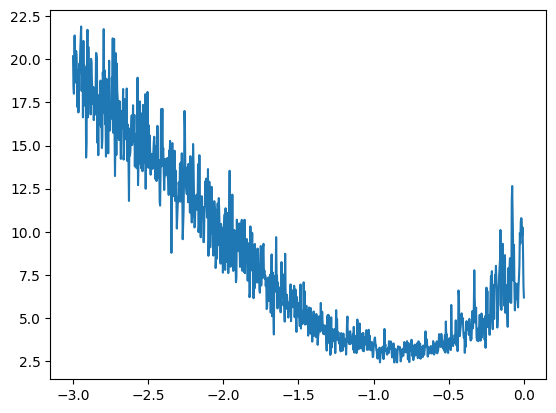

In [159]:
plt.plot(lri, lossi)

In [164]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g, requires_grad=True)

W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)

W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [165]:
for i in range(1000):

    # Adding MiniBatch Gradient Descent
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward Pass
    emb = C[X[ix]]

    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Y[ix])


    # print(loss.item())

    ## Backward pass 

    for p in parameters:
        p.grad = None

    loss.backward()

    ## Update

    ## Trying to find optimal learning rate
    lr = 0.1
    for p in parameters: 
        p.data += -lr * p.grad

print(loss)


tensor(2.8350, grad_fn=<NllLossBackward0>)


In [166]:
emb = C[X]

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)

loss

tensor(2.6563, grad_fn=<NllLossBackward0>)

In [ ]:
## Training Split, Validation Split, Test Split 
# 80%, 10%, 10%